# Plant Recognition - Inference with Quantized TFLite Model
This notebook demonstrates how to run inference on new images 
using the quantized EfficientNetB0 TFLite model.

In [1]:
# Core libraries
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

## Configuration


In [2]:
MODEL_PATH = 'models/model_quant.tflite'
IMG_SIZE = (224, 224)
TEST_DIR = 'data/new_test_images'

# ## Load class names
with open('data/processed/class_indices.json', 'r') as f:
    class_indices = json.load(f)
    CLASS_NAMES = list(class_indices.keys())

print(f"Loaded {len(CLASS_NAMES)} classes: {CLASS_NAMES}")

Loaded 9 classes: ['Bacteria', 'Early_blight', 'Fungi', 'Healthy', 'Late_blight', 'Nematode', 'Pest', 'Phytopthora', 'Virus']


## Load TFLite model


In [3]:
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\nModel input details:", input_details[0])
print("Model output details:", output_details[0])


Model input details: {'name': 'serving_default_input_layer_11:0', 'index': 0, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.uint8'>, 'quantization': (1.0, 0), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([0]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Model output details: {'name': 'StatefulPartitionedCall_1:0', 'index': 487, 'shape': array([1, 9]), 'shape_signature': array([-1,  9]), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([0]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


C:\Users\statv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


## Prediction function

In [4]:
def predict_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return "Error: Could not read image", 0.0, None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, IMG_SIZE)
    input_data = preprocess_input(np.expand_dims(img_resized, axis=0).astype(np.float32)).astype(np.uint8)
    
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # Dequantize output
    scale, zero_point = output_details[0]['quantization']
    output_data = (output_data.astype(np.float32) - zero_point) * scale
    
    predicted_idx = np.argmax(output_data)
    confidence = output_data[0][predicted_idx]
    
    class_name = CLASS_NAMES[predicted_idx] if predicted_idx < len(CLASS_NAMES) else f"Unknown class {predicted_idx}"
    return class_name, confidence, img

## Model Definition


unnamed.jpg -> Virus (0.9727)


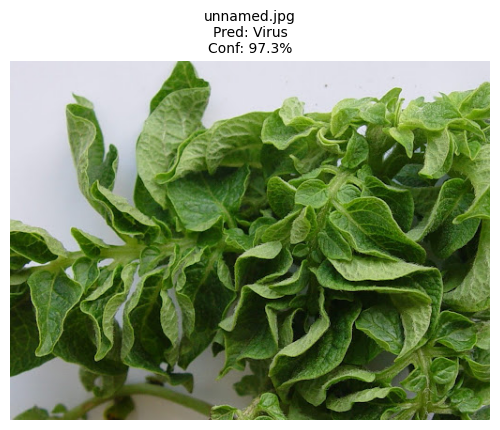

In [5]:
## Run tests on new images

if not os.path.exists(TEST_DIR):
    os.makedirs(TEST_DIR)
    print(f"Created directory: {TEST_DIR}")
    print("Please add test images and rerun the notebook.")
else:
    files = [f for f in os.listdir(TEST_DIR) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    
    if not files:
        print("No test images found. Add JPG/PNG files and rerun.")
    else:
        plt.figure(figsize=(15, 10))
        
        for i, filename in enumerate(files):
            img_path = os.path.join(TEST_DIR, filename)
            class_name, confidence, img = predict_image(img_path)
            
            plt.subplot(2, 3, i+1)
            plt.imshow(img)
            plt.title(f"{filename}\nPred: {class_name}\nConf: {confidence*100:.1f}%", fontsize=10)
            plt.axis('off')
            
            print(f"{filename} -> {class_name} ({confidence:.4f})")
        
        plt.tight_layout()
        plt.savefig('models/new_images_test.png')
        plt.show()
